# Twitter Emotion Recognition using RNN


### Step1: Setup

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize = (16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label = 'Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label = 'Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label = 'Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label = 'Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize = 'true')

    plt.figure(figsize = (8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels = classes)
    plt.yticks(list(range(0, 6)), labels = classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.3.0


### Step 2: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [4]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [6]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets,labels

In [7]:
tweets, labels = get_tweet(train)

In [8]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

### Step 3: Tokenizer

1. Tokenizing the tweets

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words = 10000, oov_token = '<UNK>')
tokenizer.fit_on_texts(tweets)

In [11]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [12]:
tweets[0]

'i didnt feel humiliated'

### Step 4: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

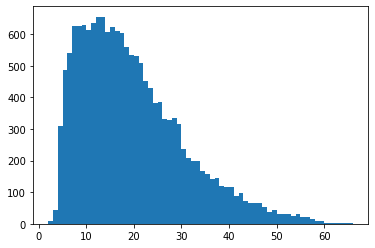

In [13]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [14]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen = maxlen)
  return padded

In [16]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [17]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

### Step 5: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [18]:
classes = set(labels)
print(classes)

{'anger', 'joy', 'sadness', 'surprise', 'love', 'fear'}


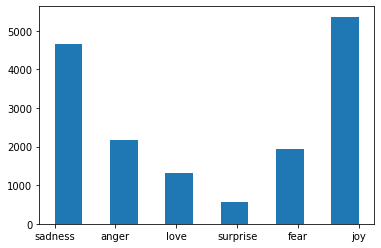

In [19]:
plt.hist(labels,bins = 11)
plt.show()

In [20]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [21]:
class_to_index

{'anger': 0, 'fear': 5, 'joy': 1, 'love': 4, 'sadness': 2, 'surprise': 3}

In [22]:
index_to_class

{0: 'anger', 1: 'joy', 2: 'sadness', 3: 'surprise', 4: 'love', 5: 'fear'}

In [23]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [24]:
train_labels = names_to_ids(labels)
print(train_labels[0])

2


### Step 6: Creating the Model

1. Creating the model
2. Compiling the model

In [26]:
model = tf.keras.models.Sequential([
      tf.keras.layers.Embedding(10000, 16, input_length = maxlen),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences = True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
      tf.keras.layers.Dense(6, activation = 'softmax')                              
])
model.compile(
    
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            160000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


### Step 7: Training the Model

1. Preparing a validation set
2. Training the model

In [28]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [29]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 2)

In [30]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs = 20,
    callbacks = [
               tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 2)
    ]
)

Epoch 1/20
500/500 [==============================] - 8s 16ms/step - loss: 1.2523 - accuracy: 0.5146 - val_loss: 0.7588 - val_accuracy: 0.7525
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.5273 - accuracy: 0.8192 - val_loss: 0.5209 - val_accuracy: 0.8225
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3163 - accuracy: 0.8994 - val_loss: 0.4604 - val_accuracy: 0.8590
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2143 - accuracy: 0.9344 - val_loss: 0.4074 - val_accuracy: 0.8740
Epoch 5/20
500/500 [==============================] - 7s 15ms/step - loss: 0.1545 - accuracy: 0.9515 - val_loss: 0.5065 - val_accuracy: 0.8650
Epoch 6/20
500/500 [==============================] - 7s 15ms/step - loss: 0.1322 - accuracy: 0.9581 - val_loss: 0.3652 - val_accuracy: 0.8845
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.0985 - accuracy: 0.9676 - val_loss: 0.3308 - val_accuracy: 0.8965

### Step 8: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

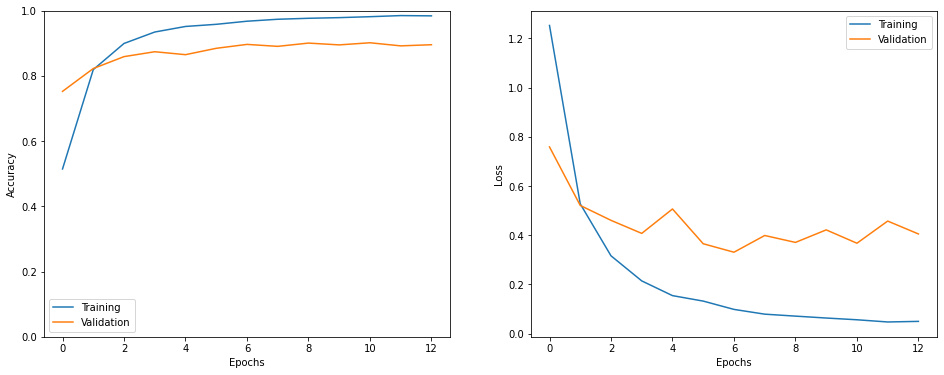

In [31]:
show_history(h)

In [32]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [33]:
model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 6ms/step - loss: 0.4029 - accuracy: 0.8985


In [48]:
i = random.randint(0, len(test_labels) - 1)

print('Sequence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis = 0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sequence: i can t help feeling lucky little do i know
Emotion: joy
Predicted Emotion: joy


In [39]:
preds = model.predict_classes(test_seq)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


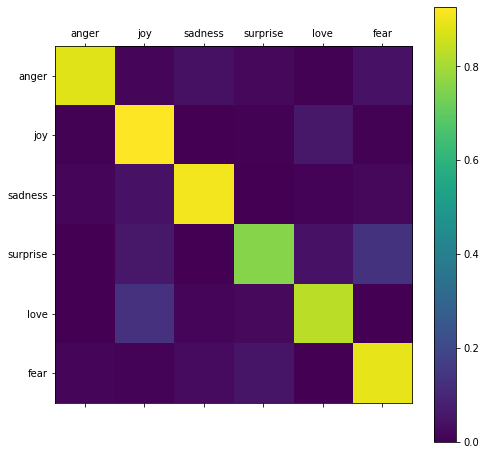

In [40]:
show_confusion_matrix(test_labels, preds, list(classes))